In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
images = []
# Load the dataset
for i in range(1, 843 + 1):
    path = f"dataset/processed/monap_{i}.png"
    img = cv2.imread(path)
    if img is None:
        # image failed to load
        continue
    else:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255
        images.append(img_rgb)
images_array = np.array(images)

In [3]:
# Splitting into 80% training and 20% test sets
train, test = train_test_split(images_array, test_size=0.2, random_state=42)

In [4]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
  def get_config(self):
    return {'latent_dim': self.latent_dim, 'shape': self.shape}


shape = test.shape[1:]
latent_dim = 128
autoencoder = Autoencoder(latent_dim, shape)

In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [6]:
autoencoder.fit(train, train,
                epochs=30,
                shuffle=True,
                validation_data=(test, test))

Epoch 1/30

22/22 [==============================] - 3s 100ms/step - loss: 0.0514 - val_loss: 0.0195
Epoch 2/30
22/22 [==============================] - 2s 90ms/step - loss: 0.0166 - val_loss: 0.0153
Epoch 3/30
22/22 [==============================] - 2s 89ms/step - loss: 0.0136 - val_loss: 0.0132
Epoch 4/30
22/22 [==============================] - 2s 88ms/step - loss: 0.0119 - val_loss: 0.0116
Epoch 5/30
22/22 [==============================] - 2s 90ms/step - loss: 0.0108 - val_loss: 0.0110
Epoch 6/30
22/22 [==============================] - 2s 93ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 7/30
22/22 [==============================] - 2s 88ms/step - loss: 0.0100 - val_loss: 0.0106
Epoch 8/30
22/22 [==============================] - 2s 88ms/step - loss: 0.0098 - val_loss: 0.0100
Epoch 9/30
22/22 [==============================] - 2s 92ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 10/30
22/22 [==============================] - 2s 93ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 1

In [7]:
encoded_imgs = autoencoder.encoder(test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

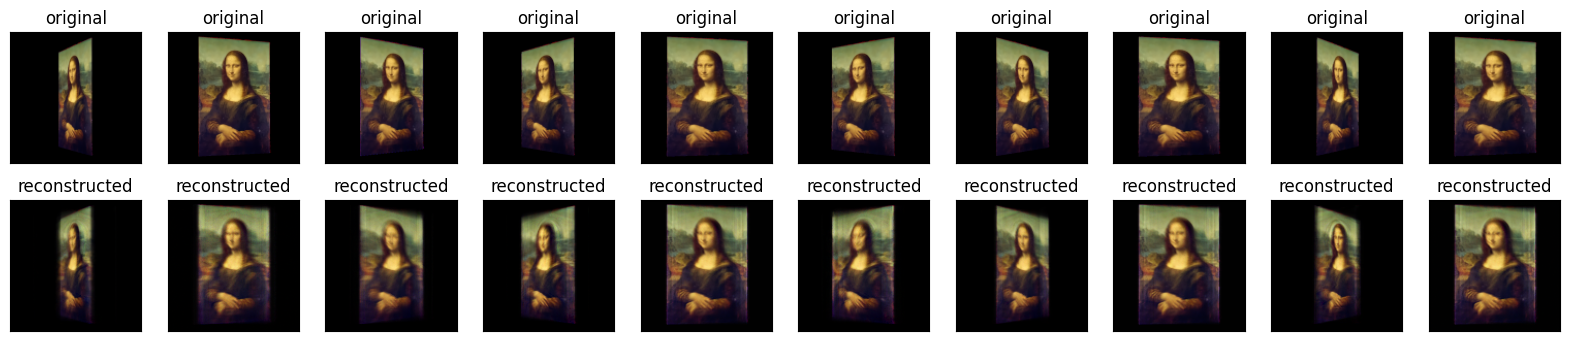

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
reconstruction_error = tf.reduce_mean(tf.square(test - decoded_imgs))

print("Reconstruction Error: ", reconstruction_error.numpy())

Reconstruction Error:  0.0007615447388675369


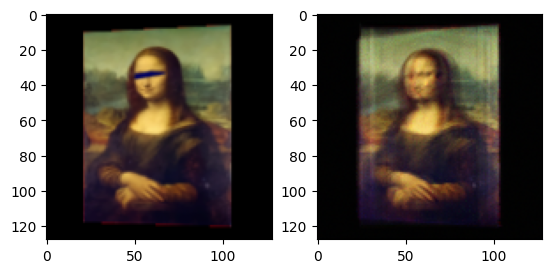

In [10]:
# lets do a test
test_img = cv2.imread(f"dataset/test/monatest_{0}.png")
test_img = np.array([cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) / 255])
plt.subplot(1,2,1)
plt.imshow(test_img[0])
enc_test = autoencoder.encoder(test_img).numpy()
dec_test = autoencoder.decoder(enc_test).numpy()
plt.subplot(1,2,2)
plt.imshow(dec_test[0])
plt.show()

In [11]:
# Get the reconstructed image
reconstructed_example = autoencoder(test_img)

# Compute the reconstruction error
reconstruction_error = tf.reduce_mean(tf.square(test_img - reconstructed_example))

print("Reconstruction Error: ", reconstruction_error.numpy())

Reconstruction Error:  0.0044730636


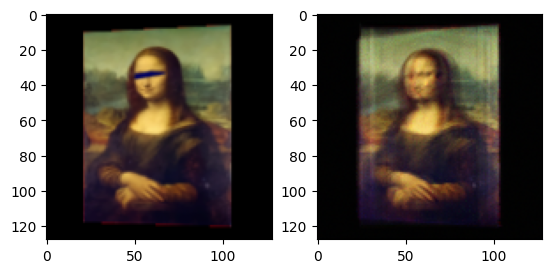

In [12]:
plt.subplot(1,2,1)
plt.imshow(test_img[0])
plt.subplot(1,2,2)
plt.imshow(reconstructed_example[0])
plt.show()

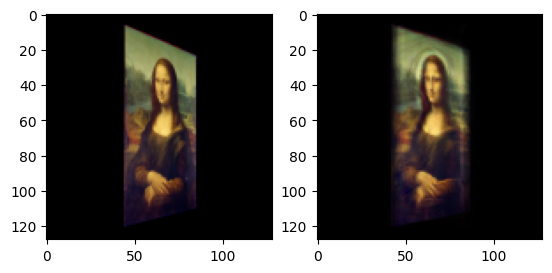

Reconstruction Error:  0.0014422212885884303


In [13]:
# lets do a test
test_img = cv2.imread(f"dataset/test/monap_522.png")
test_img = np.array([cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) / 255])
plt.subplot(1,2,1)
plt.imshow(test_img[0])
enc_test = autoencoder.encoder(test_img).numpy()
dec_test = autoencoder.decoder(enc_test).numpy()
plt.subplot(1,2,2)
plt.imshow(dec_test[0])
plt.show()

# Get the reconstructed image
# reconstructed_example = autoencoder(test_img)
reconstructed_example = dec_test

# Compute the reconstruction error
reconstruction_error = tf.reduce_mean(tf.square(test_img - reconstructed_example))

print("Reconstruction Error: ", reconstruction_error.numpy())

In [14]:
autoencoder.save("anomaly_detection_model")

INFO:tensorflow:Assets written to: anomaly_detection_model\assets


INFO:tensorflow:Assets written to: anomaly_detection_model\assets


In [15]:
model2 = tf.keras.models.load_model("anomaly_detection_model")

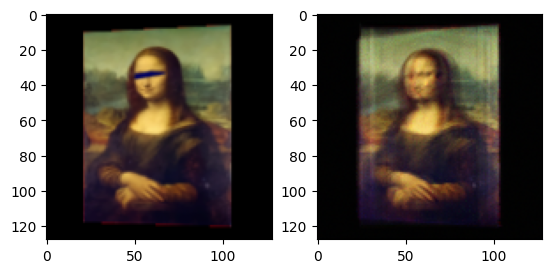

Reconstruction Error:  0.004473063971089876


In [16]:
# lets do a test
test_img_l2 = cv2.imread(f"dataset/test/monatest_{0}.png")
test_img_l2 = np.array([cv2.cvtColor(test_img_l2, cv2.COLOR_BGR2RGB) / 255])
plt.subplot(1,2,1)
plt.imshow(test_img_l2[0])
enc_test_l2 = model2.encoder(test_img_l2).numpy()
dec_test_l2 = model2.decoder(enc_test_l2).numpy()
plt.subplot(1,2,2)
plt.imshow(dec_test_l2[0])
plt.show()

# Get the reconstructed image
reconstructed_example_l2 = dec_test_l2

# Compute the reconstruction error
reconstruction_error_l2 = tf.reduce_mean(tf.square(test_img_l2 - reconstructed_example_l2))

print("Reconstruction Error: ", reconstruction_error_l2.numpy())

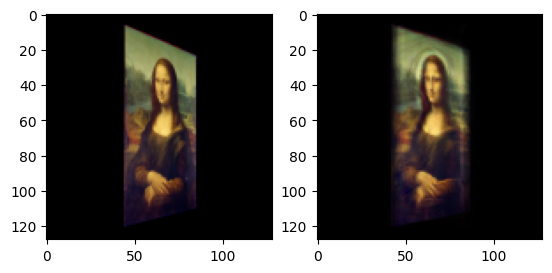

Reconstruction Error:  0.0014422212885884303


In [17]:
# lets do a test
test_img_l2 = cv2.imread(f"dataset/test/monap_522.png")
test_img_l2 = np.array([cv2.cvtColor(test_img_l2, cv2.COLOR_BGR2RGB) / 255])
plt.subplot(1,2,1)
plt.imshow(test_img_l2[0])
enc_test_l2 = model2.encoder(test_img_l2).numpy()
dec_test_l2 = model2.decoder(enc_test_l2).numpy()
plt.subplot(1,2,2)
plt.imshow(dec_test_l2[0])
plt.show()

# Get the reconstructed image
reconstructed_example_l2 = dec_test_l2

# Compute the reconstruction error
reconstruction_error_l2 = tf.reduce_mean(tf.square(test_img_l2 - reconstructed_example_l2))

print("Reconstruction Error: ", reconstruction_error_l2.numpy())